* tflite python docs -> https://www.tensorflow.org/lite/guide/inference#load_and_run_a_model_in_python
* To interpret outputs -> https://github.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/blob/master/TFLite_detection_image.py
* Use the object detection model MobileNet SSD v2 (COCO)
```
Detects the location of 80 types objects
Dataset: COCO
Input size: 300x300 so we must resize the image for processing
```

In [57]:
import argparse
import numpy as np
import os
from PIL import Image, ImageDraw
from helpers import draw_box

import tflite_runtime.interpreter as tflite

In [58]:
all_models_dir = '/home/pi/github/edgetpu/test_data/'

In [59]:
all_models = os.listdir(all_models_dir)

In [60]:
for filename in all_models:
    if 'ssd_v2' in filename:
        print(filename)

mobilenet_ssd_v2_face_quant_postprocess.tflite
mobilenet_ssd_v2_face_quant_postprocess_edgetpu.tflite
mobilenet_ssd_v2_coco_quant_postprocess_edgetpu.tflite
mobilenet_ssd_v2_coco_quant_postprocess.tflite


In [61]:
image_file = 'images/' + 'people_car.jpg'
# image = all_models_dir + 'parrot.jpg'
image_file

'images/people_car.jpg'

In [62]:
model_file = all_models_dir + 'mobilenet_ssd_v2_coco_quant_postprocess.tflite'
model_file

'/home/pi/github/edgetpu/test_data/mobilenet_ssd_v2_coco_quant_postprocess.tflite'

In [63]:
label_file = 'MobileNet_SSD_v2_COCO/coco_labels.txt'
label_file

'MobileNet_SSD_v2_COCO/coco_labels.txt'

In [64]:
# Function to read labels from text files.
def ReadLabelFile(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        lines = f.readlines()
        ret = {}
        for line in lines:
            pair = line.strip().split(maxsplit=1)
            ret[int(pair[0])] = pair[1].strip()
    return ret
    
labels = ReadLabelFile(label_file)

In [65]:
len(labels)

80

In [66]:
interpreter = tflite.Interpreter(model_path=model_file)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

This is an integer model

In [67]:
input_details[0]['dtype']

numpy.uint8

In [68]:
floating_model = input_details[0]['dtype'] == np.float32
floating_model

False

In [69]:
raw_image = Image.open(image_file)

# NxHxWxC, H:1, W:2. Note this is not maintaining aspect ratio
input_height = input_details[0]['shape'][1]
input_width = input_details[0]['shape'][2]
resized_image = Image.open(image_file).resize((input_width, input_height))

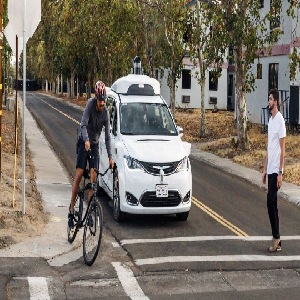

In [70]:
resized_image

In [71]:
resized_image.size

(300, 300)

In [72]:
raw_image.size

(960, 480)

In [73]:
scaling_factor = (
    raw_image.size[0]/resized_image.size[0],
    raw_image.size[1]/resized_image.size[1],
)

scaling_factor

(3.2, 1.6)

In [74]:
# add N dim
input_data = np.expand_dims(resized_image, axis=0)

In [75]:
if floating_model:
    input_data = (np.float32(input_data) - input_mean) / input_std

In [76]:
%%time
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

boxes = interpreter.get_tensor(output_details[0]['index'])[0] # Bounding box coordinates of detected objects
classes = interpreter.get_tensor(output_details[1]['index'])[0] # Class index of detected objects
scores = interpreter.get_tensor(output_details[2]['index'])[0] # Confidence of detected objects

CPU times: user 302 ms, sys: 10.8 ms, total: 312 ms
Wall time: 323 ms


In [77]:
min_conf_threshold = 0.3
image = Image.open(image_file)
draw = ImageDraw.Draw(image)

for i in range(len(scores)):
    if ((scores[i] > min_conf_threshold) and (scores[i] <= 1.0)):
        y_min = boxes[i][0] * scaling_factor[1]
        x_min = boxes[i][1] * scaling_factor[0]
        y_max = boxes[i][2] * scaling_factor[1]
        x_max = boxes[i][3] * scaling_factor[0]
        box = (y_min, x_min, y_max, x_max)
        object_name = labels[int(classes[i])] # Look up object name from "labels" array using class index
        label = '%s: %d%%' % (object_name, int(scores[i]*100)) # Example: 'person: 72%'
        draw_box(draw, box, img_width, img_height, label)


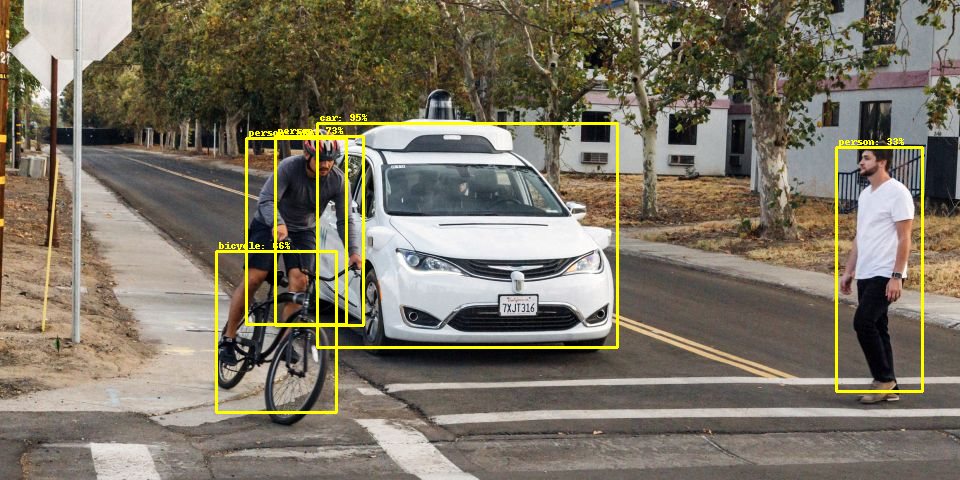

In [78]:
display(image)

